In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report,  precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Input, Dropout


In [2]:
df = pd.read_excel('df.xlsx')
print("Dimensions of the dataset:", df.shape)

nas_per_column = df.isna().sum()
columns_with_nas = nas_per_column[nas_per_column > 0]
print("\nColumns with missing values and their counts:")
print(columns_with_nas)

# to predict: without_formal_contract, envelope_wage, dep_self_empl, has_OR_would_have_undeclared_salary
#print("\nNames of columns:", df.columns.tolist())
columns_to_drop = ['without_formal_contract', 'envelope_wage', 'dep_self_empl', 'has_OR_would_have_undeclared_salary']

# Separate features and target
X = df.drop(columns=columns_to_drop, axis=1)
y = df['without_formal_contract']

# Class imbalance
print('\nClass imbalance for without_formal_contract :\n', df['without_formal_contract'].value_counts())

Dimensions of the dataset: (27565, 130)

Columns with missing values and their counts:
Series([], dtype: int64)

Class imbalance for without_formal_contract :
 0    24592
1     2973
Name: without_formal_contract, dtype: int64


# Class Balance: Undersample

In [3]:
# Define the undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resample the data
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of the resampled dataset:", X_resampled.shape)
print("Dimensions of train:", X_train.shape)
print("Dimensions of test:", X_test.shape)
print('\nClass balance for without_formal_contract :\n', y_resampled.value_counts())

Dimensions of the resampled dataset: (5946, 126)
Dimensions of train: (4756, 126)
Dimensions of test: (1190, 126)

Class balance for without_formal_contract :
 0    2973
1    2973
Name: without_formal_contract, dtype: int64


# 1. Random Forest

Training Set Accuracy: 0.8471
Test Set Accuracy: 0.8252
Confusion Matrix:
[[422 190]
 [ 18 560]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       612
           1       0.75      0.97      0.84       578

    accuracy                           0.83      1190
   macro avg       0.85      0.83      0.82      1190
weighted avg       0.86      0.83      0.82      1190



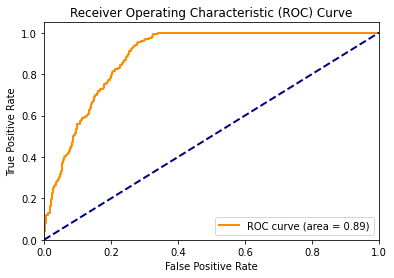

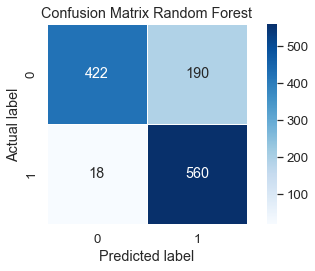

In [4]:

# Set the best parameters
best_params = {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred_RF = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF))

# ROC Curve using predicted probabilities
y_pred_proba_RF = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_RF)
roc_auc_RF = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix Random Forest')

# Adjust layout
plt.tight_layout()
plt.show()

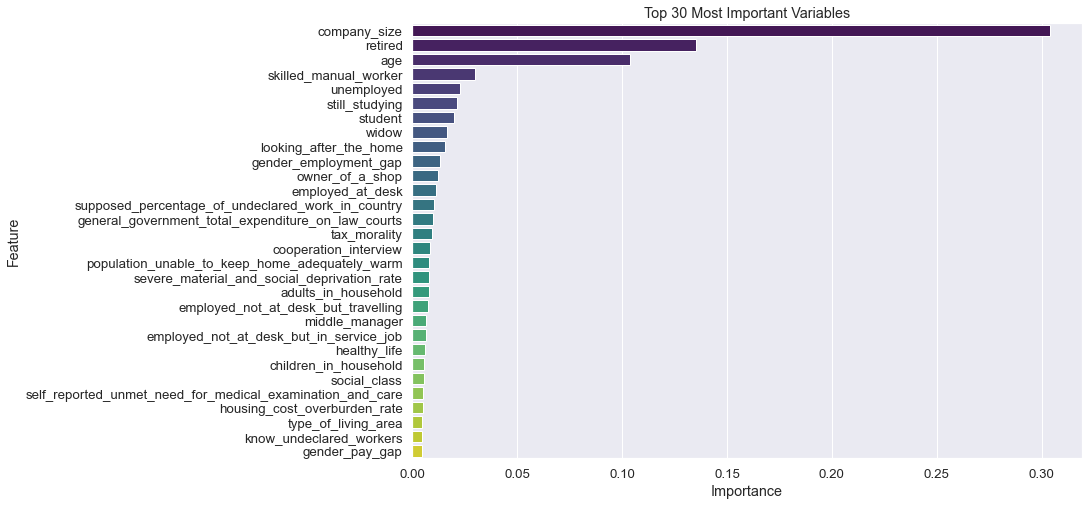

In [248]:

# Importance of variables
importances = best_rf.feature_importances_

# Get indices of top 30 features in descending order
top_indices = importances.argsort()[-30:][::-1]

# Get feature names
feature_names = X.columns

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': [feature_names[i] for i in top_indices], 'Importance': importances[top_indices]})

# Plot the importance of top 30 variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# SHAP

In [5]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for class 1
shap_values = explainer.shap_values( X_test[:100])[:, :, 1] #impact on class 1

# Calculate mean SHAP values for each feature
mean_shap_values = shap_values.mean(axis=0)

# Get feature names
feature_names = X_test.columns

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

# Display the DataFrame
print(importance_df)

                             Feature  SHAP Value    Impact
0                                age   -0.003261  Negative
1                            Belgium   -0.000114  Negative
2                            Denmark   -0.000033  Negative
3                            Germany    0.000015  Positive
4                             Greece   -0.000003  Negative
..                               ...         ...       ...
121     corruption_Perceptions_Index    0.000035  Positive
122    confidence_in_EU_institutions   -0.000140  Negative
123  official_development_assistance    0.000043  Positive
124     share_of_environmental_taxes   -0.000085  Negative
125    general_government_gross_debt   -0.000235  Negative

[126 rows x 3 columns]


In [7]:
importance_df.to_csv('wfc_importance_shap_RF_100test.csv', index=False)

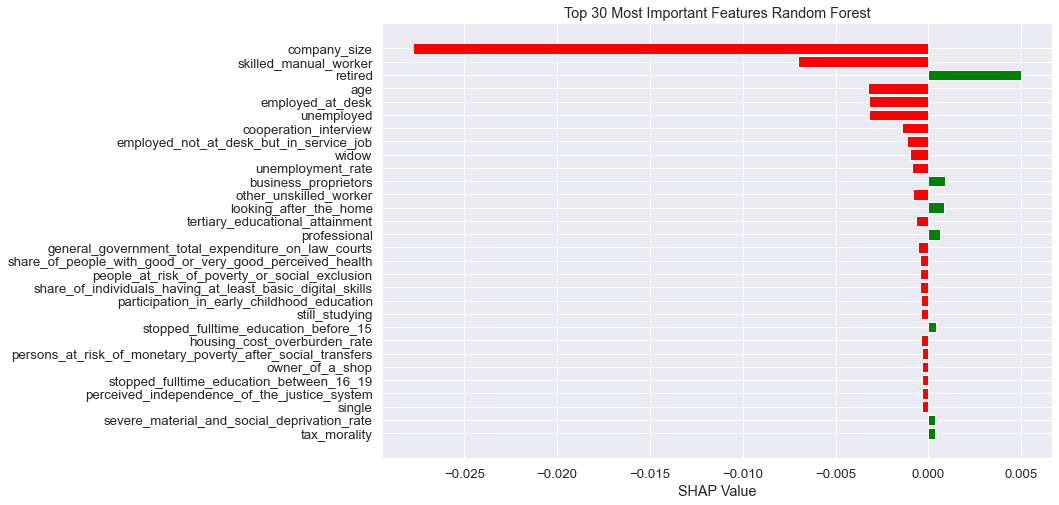

In [6]:
import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# 2. MLP Neural Network

In [4]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model final MLP

In [5]:
#4.0	[126, 64]	['relu', 'relu']	binary_crossentropy	Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import shap
import pandas as pd

# Set seeds for reproducibility
np.random.seed(140)
tf.keras.utils.set_random_seed(44)
tf.random.set_seed(134)

# Initialize the model
model_MLP = Sequential(name='MLP')

# Add layers directly with numbers
model_MLP.add(Dense(126, activation='tanh', input_shape=(126,)))
model_MLP.add(Dense(126, activation='tanh'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(64, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(1, activation='sigmoid'))

# Compile the model
model_MLP.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Fit the model
model_MLP.fit(X_train, y_train, epochs=5, batch_size=1, verbose=0)


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# SHAP

In [6]:
explainer_MLP = shap.KernelExplainer(model_MLP.predict,X_train)
shap_values_MLP = explainer_MLP.shap_values(X_test[:100],nsamples=100)

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


Using 4756 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 734us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 735us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 731us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 705us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 714us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 713us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 760us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 721us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 722us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 703us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
14863/14863 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 68 iterations, alpha=1.742e-04, previous alpha=1.742e-04, with an active set of 39 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 681us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 686us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 698us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 707us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 691us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 704us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 688us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 683us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 731us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 737us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 708us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14863/14863 ━━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=7.765e-04, with an active set of 28 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=5.874e-04, with an active set of 34 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 698us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 719us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 690us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 695us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 690us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 705us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 709us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 701us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 697us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14863/14863 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.670e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=8.401e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alph

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 699us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 695us/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 58 iterations, alpha=4.385e-04, previous alpha=4.141e-04, with an active set of 39 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 685us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 697us/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=2.344e-04, with an active set of 34 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 53 iterations, alpha=2.344e-04, previous alpha=2.329e-04, with an active set of 34 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 718us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 693us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 697us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 695us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 700us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 707us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 697us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 687us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 695us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 698us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14863/14863 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=1.251e-04, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 88 iterations, alpha=3.700e-05, previous alpha=3.700e-05, with an active set of 45 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 693us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 691us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 689us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 694us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 700us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 11s 708us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 703us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 703us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 697us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14863/14863 ━━━━━━━━━━━━━━━━━━━━ 10s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14863/14863 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=7.441e-05, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 86 iterations, alpha=2.931e-05, previous alpha=2.929e-05, with an active set of 47 regressors.
  warnings.warn(


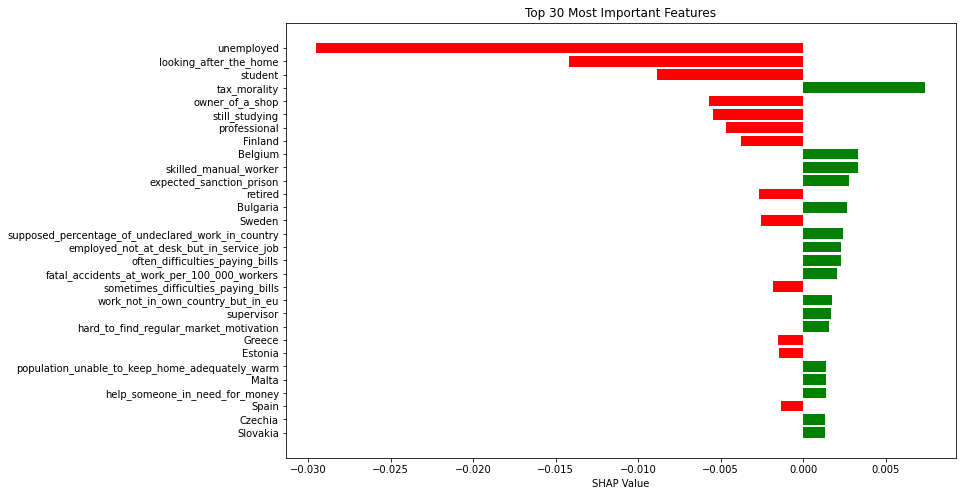

In [7]:
# Calculate mean SHAP values for each feature
mean_shap_values = shap_values_MLP.mean(axis=0).mean(axis=1)

# Get feature names
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [11]:
importance_df.to_csv('wtf_importance_shap_MLP_100test.csv', index=False)

# FARA TARI

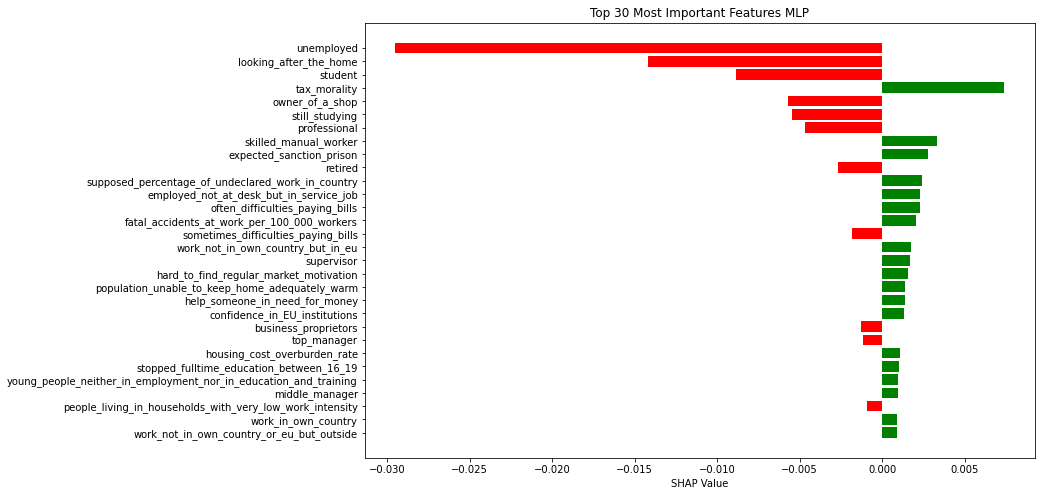

In [9]:
# FARA TARI
importance_df = pd.read_csv('importance_shap_MLP_100test_ew.csv')
importance_df= importance_df.drop(df.index[1:30])   #cut out countries


# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features MLP')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# 3. Tab Net with CV

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Ensure reproducibility
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert pandas DataFrame to numpy array
X_train_array = X_train.values
X_test_array = X_test.values

# Define TabNetClassifier model
tabnet_model = TabNetClassifier()

# Define cross-validation strategy (Stratified K-Fold with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on training set
cv_scores = cross_val_score(tabnet_model, X_train_array, y_train, cv=skf, scoring='accuracy')

# Fit the model to the entire training data
tabnet_model.fit(X_train_array, y_train) 




C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.99405 |  0:00:00s
epoch 1  | loss: 0.76649 |  0:00:00s
epoch 2  | loss: 0.73688 |  0:00:00s
epoch 3  | loss: 0.68121 |  0:00:01s
epoch 4  | loss: 0.65561 |  0:00:01s
epoch 5  | loss: 0.62336 |  0:00:01s
epoch 6  | loss: 0.5999  |  0:00:02s
epoch 7  | loss: 0.57546 |  0:00:02s
epoch 8  | loss: 0.56056 |  0:00:02s
epoch 9  | loss: 0.5436  |  0:00:02s
epoch 10 | loss: 0.52216 |  0:00:03s
epoch 11 | loss: 0.50611 |  0:00:03s
epoch 12 | loss: 0.51218 |  0:00:03s
epoch 13 | loss: 0.49742 |  0:00:03s
epoch 14 | loss: 0.48686 |  0:00:04s
epoch 15 | loss: 0.49085 |  0:00:04s
epoch 16 | loss: 0.47747 |  0:00:04s
epoch 17 | loss: 0.46099 |  0:00:05s
epoch 18 | loss: 0.45695 |  0:00:05s
epoch 19 | loss: 0.45342 |  0:00:05s
epoch 20 | loss: 0.4347  |  0:00:05s
epoch 21 | loss: 0.43884 |  0:00:06s
epoch 22 | loss: 0.43185 |  0:00:06s
epoch 23 | loss: 0.42251 |  0:00:06s
epoch 24 | loss: 0.42906 |  0:00:06s
epoch 25 | loss: 0.42678 |  0:00:07s
epoch 26 | loss: 0.42628 |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.97166 |  0:00:00s
epoch 1  | loss: 0.81286 |  0:00:00s
epoch 2  | loss: 0.73113 |  0:00:00s
epoch 3  | loss: 0.66846 |  0:00:01s
epoch 4  | loss: 0.64947 |  0:00:01s
epoch 5  | loss: 0.60961 |  0:00:01s
epoch 6  | loss: 0.5942  |  0:00:01s
epoch 7  | loss: 0.57973 |  0:00:02s
epoch 8  | loss: 0.54522 |  0:00:02s
epoch 9  | loss: 0.52815 |  0:00:02s
epoch 10 | loss: 0.51488 |  0:00:03s
epoch 11 | loss: 0.49347 |  0:00:03s
epoch 12 | loss: 0.46456 |  0:00:03s
epoch 13 | loss: 0.44924 |  0:00:03s
epoch 14 | loss: 0.43469 |  0:00:04s
epoch 15 | loss: 0.42792 |  0:00:04s
epoch 16 | loss: 0.40826 |  0:00:04s
epoch 17 | loss: 0.41342 |  0:00:05s
epoch 18 | loss: 0.39275 |  0:00:05s
epoch 19 | loss: 0.39067 |  0:00:05s
epoch 20 | loss: 0.38515 |  0:00:05s
epoch 21 | loss: 0.39961 |  0:00:06s
epoch 22 | loss: 0.38886 |  0:00:06s
epoch 23 | loss: 0.38632 |  0:00:06s
epoch 24 | loss: 0.38227 |  0:00:06s
epoch 25 | loss: 0.38034 |  0:00:07s
epoch 26 | loss: 0.3826  |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.96928 |  0:00:00s
epoch 1  | loss: 0.77069 |  0:00:00s
epoch 2  | loss: 0.73204 |  0:00:00s
epoch 3  | loss: 0.68828 |  0:00:01s
epoch 4  | loss: 0.65635 |  0:00:01s
epoch 5  | loss: 0.63928 |  0:00:01s
epoch 6  | loss: 0.6135  |  0:00:01s
epoch 7  | loss: 0.57921 |  0:00:02s
epoch 8  | loss: 0.55143 |  0:00:02s
epoch 9  | loss: 0.5295  |  0:00:02s
epoch 10 | loss: 0.51911 |  0:00:03s
epoch 11 | loss: 0.50632 |  0:00:03s
epoch 12 | loss: 0.49758 |  0:00:03s
epoch 13 | loss: 0.48484 |  0:00:03s
epoch 14 | loss: 0.4637  |  0:00:04s
epoch 15 | loss: 0.47132 |  0:00:04s
epoch 16 | loss: 0.46041 |  0:00:04s
epoch 17 | loss: 0.43248 |  0:00:05s
epoch 18 | loss: 0.42993 |  0:00:05s
epoch 19 | loss: 0.42904 |  0:00:05s
epoch 20 | loss: 0.40366 |  0:00:05s
epoch 21 | loss: 0.42632 |  0:00:06s
epoch 22 | loss: 0.4028  |  0:00:06s
epoch 23 | loss: 0.40136 |  0:00:06s
epoch 24 | loss: 0.40473 |  0:00:07s
epoch 25 | loss: 0.40206 |  0:00:07s
epoch 26 | loss: 0.40231 |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.01059 |  0:00:00s
epoch 1  | loss: 0.78358 |  0:00:00s
epoch 2  | loss: 0.71977 |  0:00:00s
epoch 3  | loss: 0.68364 |  0:00:01s
epoch 4  | loss: 0.65847 |  0:00:01s
epoch 5  | loss: 0.63812 |  0:00:01s
epoch 6  | loss: 0.61481 |  0:00:01s
epoch 7  | loss: 0.59124 |  0:00:02s
epoch 8  | loss: 0.57861 |  0:00:02s
epoch 9  | loss: 0.54665 |  0:00:02s
epoch 10 | loss: 0.5215  |  0:00:03s
epoch 11 | loss: 0.5117  |  0:00:03s
epoch 12 | loss: 0.47991 |  0:00:03s
epoch 13 | loss: 0.4655  |  0:00:03s
epoch 14 | loss: 0.44498 |  0:00:04s
epoch 15 | loss: 0.43155 |  0:00:04s
epoch 16 | loss: 0.42608 |  0:00:04s
epoch 17 | loss: 0.40688 |  0:00:04s
epoch 18 | loss: 0.40547 |  0:00:05s
epoch 19 | loss: 0.40314 |  0:00:05s
epoch 20 | loss: 0.39996 |  0:00:05s
epoch 21 | loss: 0.39215 |  0:00:06s
epoch 22 | loss: 0.38559 |  0:00:06s
epoch 23 | loss: 0.38945 |  0:00:06s
epoch 24 | loss: 0.38823 |  0:00:06s
epoch 25 | loss: 0.38596 |  0:00:07s
epoch 26 | loss: 0.3846  |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.95931 |  0:00:00s
epoch 1  | loss: 0.76597 |  0:00:00s
epoch 2  | loss: 0.74052 |  0:00:00s
epoch 3  | loss: 0.69046 |  0:00:01s
epoch 4  | loss: 0.66065 |  0:00:01s
epoch 5  | loss: 0.63837 |  0:00:01s
epoch 6  | loss: 0.60028 |  0:00:01s
epoch 7  | loss: 0.57315 |  0:00:02s
epoch 8  | loss: 0.5391  |  0:00:02s
epoch 9  | loss: 0.53261 |  0:00:02s
epoch 10 | loss: 0.52475 |  0:00:03s
epoch 11 | loss: 0.50665 |  0:00:03s
epoch 12 | loss: 0.48769 |  0:00:03s
epoch 13 | loss: 0.48073 |  0:00:03s
epoch 14 | loss: 0.45838 |  0:00:04s
epoch 15 | loss: 0.44167 |  0:00:04s
epoch 16 | loss: 0.42635 |  0:00:04s
epoch 17 | loss: 0.42199 |  0:00:04s
epoch 18 | loss: 0.40299 |  0:00:05s
epoch 19 | loss: 0.39858 |  0:00:05s
epoch 20 | loss: 0.39975 |  0:00:05s
epoch 21 | loss: 0.39008 |  0:00:06s
epoch 22 | loss: 0.39252 |  0:00:06s
epoch 23 | loss: 0.39478 |  0:00:06s
epoch 24 | loss: 0.39209 |  0:00:06s
epoch 25 | loss: 0.38365 |  0:00:07s
epoch 26 | loss: 0.38428 |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.93125 |  0:00:00s
epoch 1  | loss: 0.75909 |  0:00:00s
epoch 2  | loss: 0.71176 |  0:00:01s
epoch 3  | loss: 0.67441 |  0:00:01s
epoch 4  | loss: 0.62919 |  0:00:01s
epoch 5  | loss: 0.60239 |  0:00:02s
epoch 6  | loss: 0.57693 |  0:00:02s
epoch 7  | loss: 0.56216 |  0:00:03s
epoch 8  | loss: 0.54951 |  0:00:03s
epoch 9  | loss: 0.53264 |  0:00:03s
epoch 10 | loss: 0.49548 |  0:00:04s
epoch 11 | loss: 0.47796 |  0:00:04s
epoch 12 | loss: 0.45953 |  0:00:04s
epoch 13 | loss: 0.44337 |  0:00:05s
epoch 14 | loss: 0.42381 |  0:00:05s
epoch 15 | loss: 0.41711 |  0:00:06s
epoch 16 | loss: 0.40953 |  0:00:06s
epoch 17 | loss: 0.40206 |  0:00:06s
epoch 18 | loss: 0.40147 |  0:00:07s
epoch 19 | loss: 0.39824 |  0:00:07s
epoch 20 | loss: 0.39649 |  0:00:07s
epoch 21 | loss: 0.39475 |  0:00:08s
epoch 22 | loss: 0.39923 |  0:00:08s
epoch 23 | loss: 0.39424 |  0:00:09s
epoch 24 | loss: 0.3913  |  0:00:09s
epoch 25 | loss: 0.38943 |  0:00:09s
epoch 26 | loss: 0.38944 |  0:00:10s
e

Top 30 Feature Importances:
                                               Feature  Importance
37                                             retired    0.298955
71                                        company_size    0.288759
34                              looking_after_the_home    0.045447
114                                  unemployment_rate    0.033731
5                                                Spain    0.020478
35                                             student    0.019827
58                            expected_sanction_prison    0.017631
32                     interested_in_european_politics    0.015646
1                                              Belgium    0.015606
77                                              single    0.015415
46                                    employed_at_desk    0.015053
83            stopped_fulltime_education_between_16_19    0.014891
76                                  politics_undecided    0.014503
61                               t

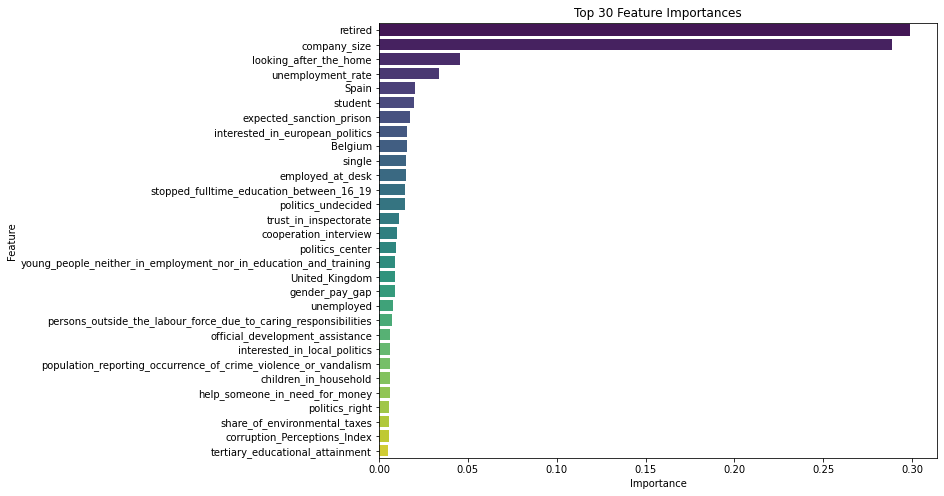

In [5]:

# Calculate feature importance
feature_importances = tabnet_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # If X_train is a DataFrame; if not, replace this with appropriate feature names
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 30 most important features
top_30_features = feature_importance_df.head(30)

# Print top 30 feature importance
print("Top 30 Feature Importances:")
print(top_30_features)

# Plot top 30 feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# SHAP

In [6]:
import shap

# Define the number of samples (K) for summarizing the background data
K = 100

# Use shap.kmeans() to summarize the background data
background_summary = shap.kmeans(X_train, K)

# Initialize the KernelExplainer with the summarized background data
explainer_TabNet= shap.KernelExplainer(tabnet_model.predict, background_summary)

# Calculate SHAP values using the KernelExplainer
shap_values_TabNet = explainer_TabNet.shap_values(X_test[:100], nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.430e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_a

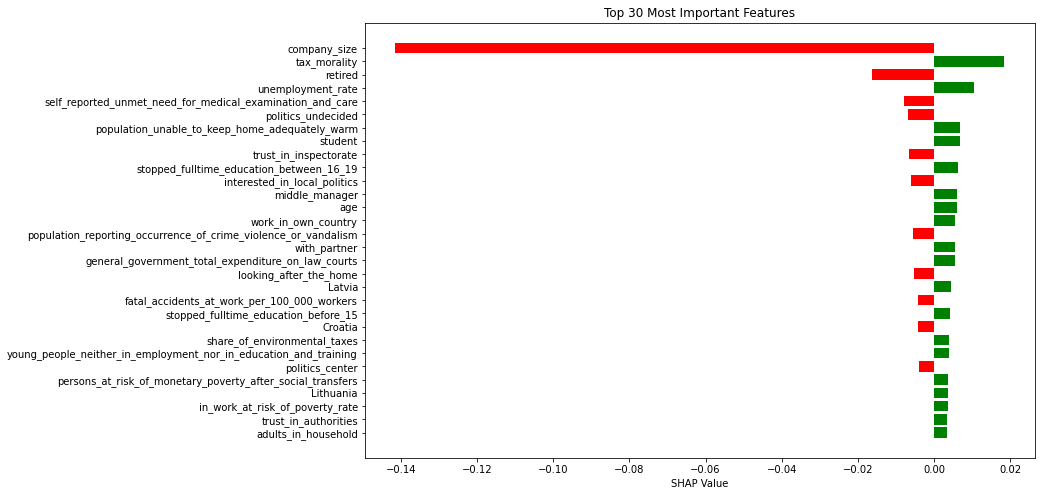

In [7]:
# Calculate mean SHAP values across the samples
mean_shap_values = shap_values_TabNet.mean(axis=0)

# Get feature names
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [8]:
importance_df.to_csv('wfc_importance_shap_TabNet_100test.csv', index=False)

# Fara tari

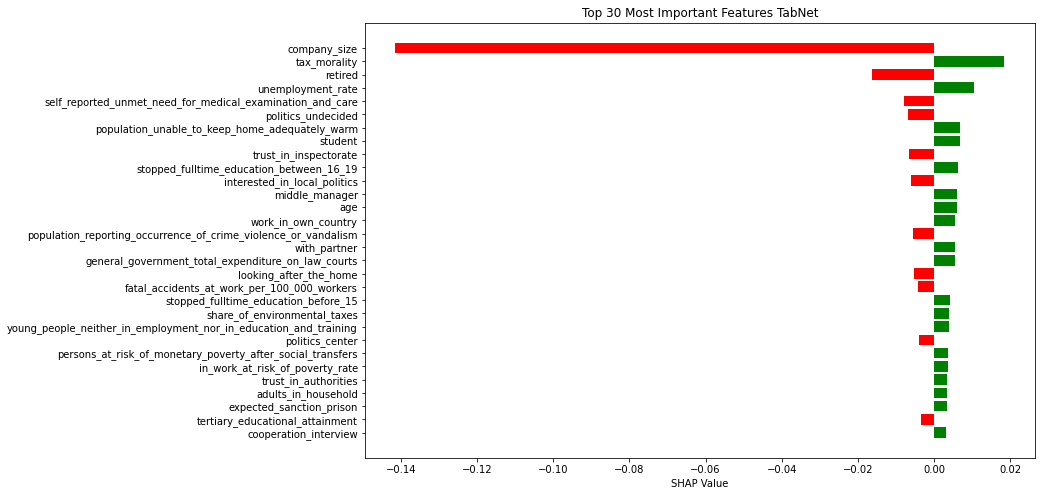

In [10]:
# FARA TARI
importance_df = pd.read_csv('wfc_importance_shap_TabNet_100test.csv')
importance_df= importance_df.drop(df.index[1:30])   #cut out countries


# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features TabNet')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# 4. Convolutional Neural Networks

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#SET SEED
np.random.seed(140)
tf.random.set_seed(134)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dimensions of X_train: (4756, 126)
Dimensions of X_test: (1190, 126)
Dimensions of y_train: (4756,)
Dimensions of y_test: (1190,)


In [12]:

#Reshape the data into 2D grid-like structure based on the data's dimensions
# Here, we reshape it into a 14x9 grid
X_train_reshaped = X_train_scaled.reshape(-1, 14, 9, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 14, 9, 1)
print("Dimensions of X_train_reshaped:", X_train_reshaped.shape)
print("Dimensions of X_test_reshaped:", X_test_reshaped.shape)


Dimensions of X_train_reshaped: (4756, 14, 9, 1)
Dimensions of X_test_reshaped: (1190, 14, 9, 1)


## MODEL CNN FINAL 

In [15]:
#1.0	1.0 	1.0 	2.0 	[128, 32, 32]	['tanh', 'tanh', 'relu']	binary_crossentropy 	Adam

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)

# Define and compile the CNN model
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model_CNN.fit(X_train_reshaped, y_train, epochs=5, batch_size=1,  shuffle=False)



Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7146 - loss: 0.5369
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7999 - loss: 0.4072
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8108 - loss: 0.3894
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8146 - loss: 0.3790
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8158 - loss: 0.3783


Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7111 - loss: 0.5445
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7987 - loss: 0.4166
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8104 - loss: 0.3984
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8162 - loss: 0.3872
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8173 - loss: 0.3833


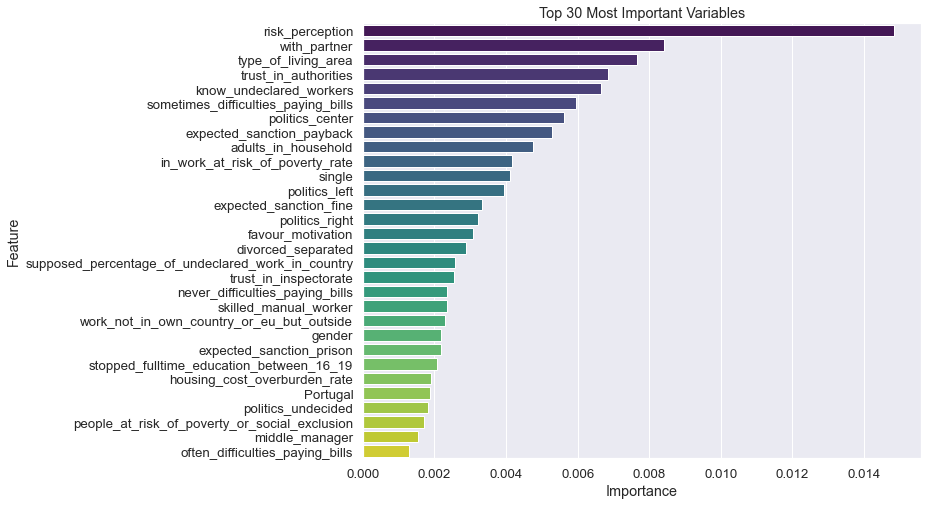

In [238]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set seeds for reproducibility
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)

# Define your CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=1, shuffle=False)

# Function to compute integrated gradients
@tf.function
def integrated_gradients(input_data):
    baseline = tf.zeros_like(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
    grads = tape.gradient(predictions, input_data)
    integrated_grads = (input_data - baseline) * grads
    return tf.reduce_mean(integrated_grads, axis=0)

# Compute integrated gradients for each sample in the test set
ig_list = []
for sample in X_test_reshaped:
    ig = integrated_gradients(tf.convert_to_tensor([sample]))
    ig_list.append(ig.numpy())

# Calculate the mean importance across the test set
feature_importance = np.mean(ig_list, axis=0)

# Flatten feature_importance if it's not already 1D
feature_importance = feature_importance.flatten()

# Assuming X_train_reshaped was reshaped from a DataFrame X, with columns corresponding to the original feature names
input_feature_names = [f"Feature_{i}" for i in range(X_train_reshaped.shape[1] * X_train_reshaped.shape[2])]
input_feature_names = list(X.columns)

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': input_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the top 30 most important variables
top_30_importance_df = importance_df.head(30)

# Plot the importance of top 30 variables
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()


# SHAP

In [16]:
# Define a function to predict with the model and reshape the input
def predict_with_reshape(data):
    reshaped_data = data.reshape(-1, 14, 9, 1)
    return model_CNN.predict(reshaped_data)

# Define the number of samples (K) for summarizing the background data
K = 100

# Use shap.kmeans() to summarize the background data
background_summary = shap.kmeans(X_train_reshaped.reshape(X_train_reshaped.shape[0], -1), K)

# Initialize the KernelExplainer with the summarized background data
explainer_CNN = shap.KernelExplainer(predict_with_reshape, background_summary)


# Select the first 100 samples from the test set
X_test_reshaped_first_100 = X_test_reshaped[:100]
X_test_reshaped_first_100_flat = X_test_reshaped_first_100.reshape(X_test_reshaped_first_100.shape[0], -1)

# Calculate SHAP values using the KernelExplainer
shap_values_CNN = explainer_CNN.shap_values(X_test_reshaped_first_100_flat, nsamples=100)

# Reshape SHAP values to original 14x9 features
shap_values_original = np.array(shap_values_CNN).reshape(-1, 14, 9)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.086e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=1.053e-02, previous alpha=1.053e-02, with an active set of 21 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.587e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=6.973e-04, previous alpha=6.678e-04, with an active set of 30 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.445e-04, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=6.621e-05, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=2.487e-05, with an active set of 43 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 95 iterations, alpha=1.088e-05, previous alpha=1.088e-05, with an active set of 46 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


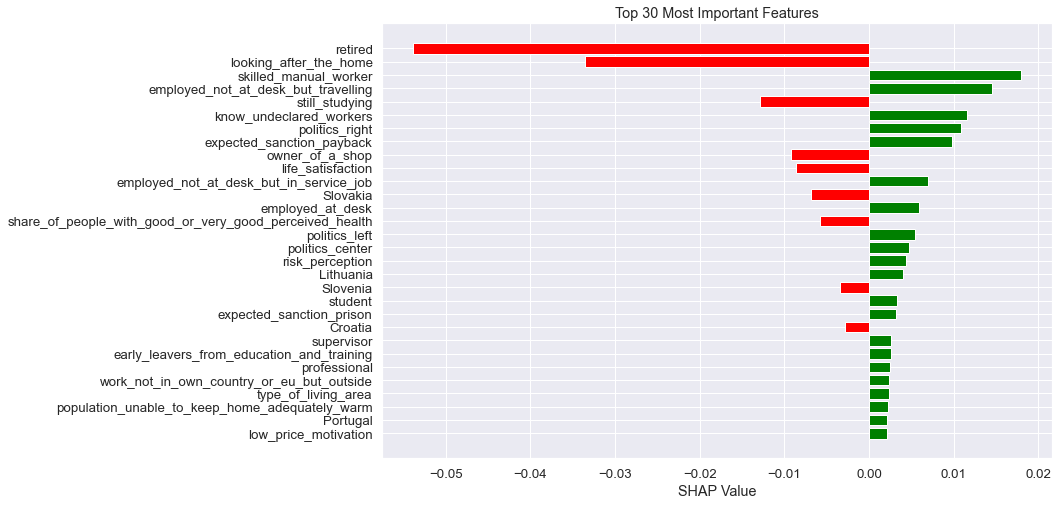

In [17]:
# Calculate mean SHAP values for each feature
mean_shap_values = shap_values_original.mean(axis=0)

# Get feature names (assuming you have feature names in X.columns)
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values.flatten()})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values.flatten()]


# Get the top 30 most important features
import matplotlib.pyplot as plt
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [18]:
importance_df.to_csv('wfc_importance_shap_CNN_100test.csv', index=False)

# Fara TARI

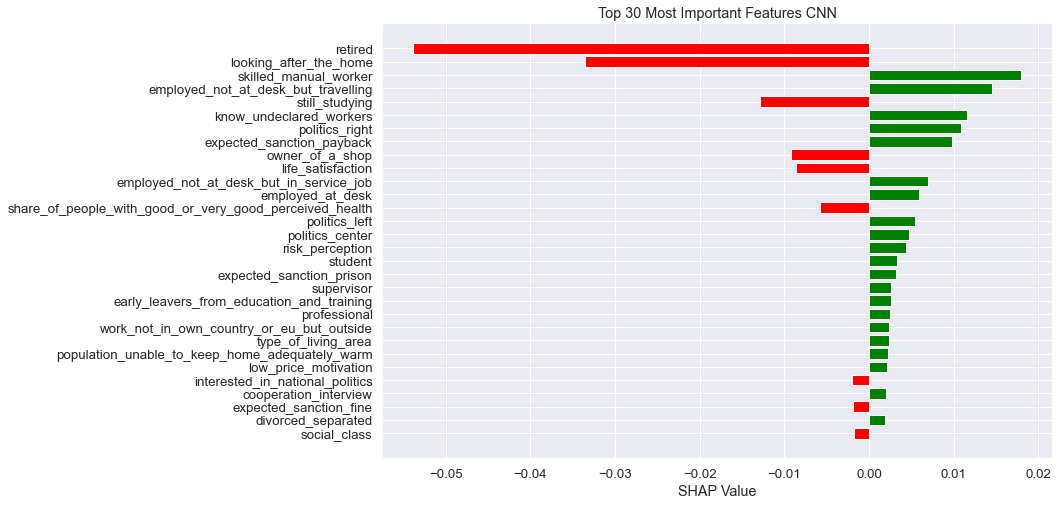

In [20]:
# FARA TARI
importance_df = pd.read_csv('wfc_importance_shap_CNN_100test.csv')
importance_df= importance_df.drop(df.index[1:30])   #cut out countries


# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features CNN')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()